# Quick Start

-----
<a id='top'></a>

## DiscoTimeS

<div style="height:10px;"></div>

- [// Why discotimes?](#why)
- [// Setting up the data/model](#setup)
- [// Running the model](#running)
- [// Plotting and Visualization](#plotting-and-visualization)
- [// Model output](#output)
- [// Command line interface - Fitting multiple files](#cli)
- [// References](#References)

-----

<a id='why'></a>
### Why DiscoTimeS?

DiscoTimeS is a tool to estimate DISCOntinuities in TIME Series. It is particularly designed for geophyiscal time series, i.e., long (~years to decadal) observations from GPS and 'satellite altimetry minus tide gauge' data, but can be applied to any kind of data with similar features.
It estimates the following components:

* base trend
* base offset
* change points
* change point positions
* discontinuities
* incremental trend changes
* multiyear monthly-mean annual cycle
* Noise properties of residuals (currently only AR1)

#### Model definition

The trends g(t) and offsets o(t) are therefore time dependent components of the model:

\begin{equation}
y(t) = o(t) + g(t) + seas  + \eta  \label{eq:02}
\end{equation}

#### Model fitting

The model parameter are simultaneously estimated within a Bayesian Framework. The model implementation, the distribution setups and the sampling algorithms are all based on PyMC3, an extensive python-library to setup Bayesian models (see https://docs.pymc.io/). More information on the exact implementation is given in the paper.

[back to top ](#top)

-----
### Setting up the data/model
<a id='setup'></a>

This section describes the model usage in a python IDE. Please go to section [Command line interface - Fitting multiple files](#cli) for the CLI implementation.

To set up the model import the discotimes class and the standard model settings and have a look into the model settings.

In [74]:
from discotimes.discotimes import discotimes as dt
from discotimes.model_settings import set_settings
settings = set_settings()
settings

{'model_settings': {'n_changepoints': 5,
  'offsets_std': 20.0,
  'model': None,
  'name': '',
  'change_trend': True,
  'change_offsets': True,
  'n_samples': 8000,
  'trend_inc_sigma': 1.0,
  'post_seismic': False,
  'estimate_offset_sigma': True,
  'estimate_trend_inc_sigma': True,
  'annual_cycle': True,
  'AR1': True,
  'p_': 0.1,
  'initial_values': {}},
 'run_settings': {'n_samples': 8000,
  'tune': 2000,
  'cores': 8,
  'nuts': {'target_accept': 0.9},
  'return_inferencedata': True,
  'compress': True},
 'initial_run_settings': {'detection_threshold': 15,
  'detection_resolution': 4,
  'method': 'diff'}}

The dictionary contains information required for the priors ('model_settings'), the sampling ('run_settings'), as well as some information for a pre-fit discontinuity detection ('initial_run_settings'). 


#### Model settings
You can change the model settings to meet your requirements: If you don't want to allow for trend changes (but still for discontinuities) set 'change_trend' to False. Change 'n_changepoints' for a different number of maximum allowed change points, or set the assumption initial probability of change points to occur to 30%, e.g.  

In [75]:
settings['model_settings']['p_']= 0.3

#### Run settings
Control the number of cores ('cores') used or the number of sampling iterations ('n_samples'). You can also control settings of the NUTS sampler (https://docs.pymc.io/api/inference.html)

#### Data input
Now load some data. We use a GNSS height time series, which is can be downloaded from the repository in discotimes/examples/G103.txt. Note that we use file_reader, which can handle different types of input data like .tenv3, .txyz2, .txt, .csv and netcdf. Data in .txt or .csv files should have a variable column named 'Height' (default, otherwise define variable), and a date column ('Year'), specifying the date like 2000.2342. The output is a pd.Series object.

You can also input the variable names as column indices (e.g., variable = 2). Please refer to, e.g., http://geodesy.unr.edu/gps_timeseries/README_txyz2.txt, http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/0ARK.tenv3, for more information on .tenv3 and .txyz2 files. 

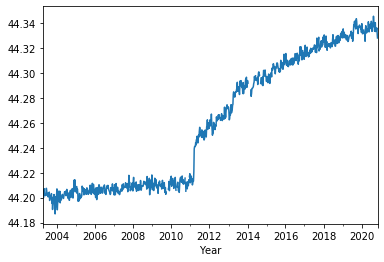

In [2]:
from discotimes.discotimes import file_reader 
file = 'discotimes/examples/G103.txt'
series = file_reader(file,variable='auto',resample='W')
series.plot()

#### Model setup
Now setup the model and name it!

In [1]:
from discotimes.discotimes import file_reader 
from discotimes.discotimes import discotimes as dt
from discotimes.model_settings import set_settings
settings = set_settings()
file = 'discotimes/examples/G103.txt'
series = file_reader(file,variable='auto',resample='W')

In [5]:
series

Year
2003-04-06    44.200050
2003-04-13    44.201966
2003-04-20    44.199864
2003-04-27    44.201558
2003-05-04    44.207151
                ...    
2020-10-04    44.334253
2020-10-11    44.334183
2020-10-18    44.336156
2020-10-25    44.332631
2020-11-01    44.328080
Freq: W-SUN, Name: Height, Length: 918, dtype: float64

In [2]:
dt_model = dt(series,settings=settings,name='G103')

Normalize data
Frequency: W
first:  2003-04-06 00:00:00  last:  2020-11-01 00:00:00


The normalized data can be assessed with

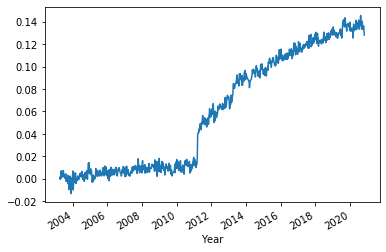

In [3]:
dt_model.obs.series_clean.plot()

[back to top ](#top)

-----
### Running the model
<a id='running'></a>

Now run the model! Here we set only 4 chains and 2000 iterations.

In [4]:
settings['run_settings']['n_samples']=2000
settings['run_settings']['cores']=4
dt_model.run(**settings['run_settings'])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta, m_coeffs, trend_inc, trend_inc_sigma_est, positions, mu_pos, offsets, offset_sigma, sigma, trend, offset]
>BinaryGibbsMetropolis: [act_number]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1795 seconds.
The acceptance probability does not match the target. It is 0.9860648007646505, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8060834909645324, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7963204852816973, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rh

successfully compressed trace


The trace was compressed after running the model. That means we only retain the mean and the standard-deviation of every parameter, not the full Markov Chain. To keep the full Markov chain use:

In [28]:
# dt_model.run(keep_trace=True,**settings['run_settings'])

The un-compressed trace will then be available in dt_model.trace['full_trace']

To save and load the model use:

In [ ]:
filed = 'discotimes/examples/'
dt_model.save(save_dir=filed)
dt_model=dt.load(save_dir=filed,name='G103')

[back to top ](#top)

<hr>

### Plotting and Visualization
<a id='plotting-and-visualization'></a>

Now plot the posterior means of the Markov Chains

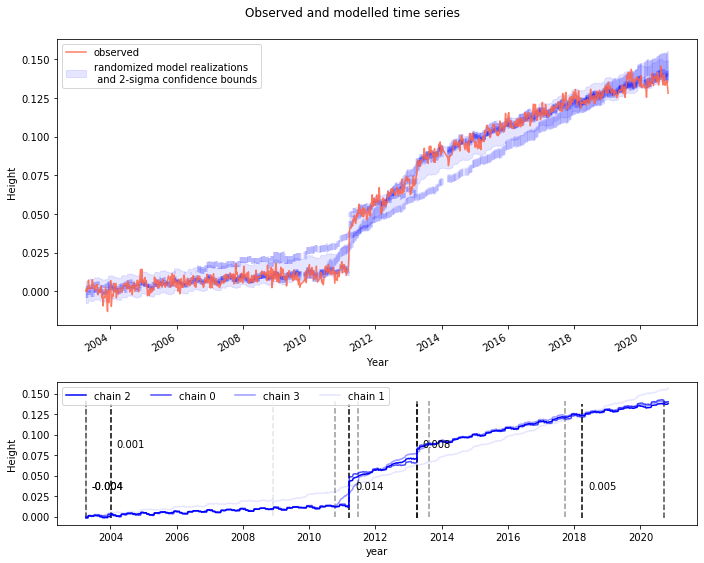

In [20]:
dt_model.plot() 

As can be seen, the 4 chains behave differently. Chain 2 is here selected as the best possible fit. The selection is based on the lowest loo, as also described in the paper. There are different model selection options as noted in the next section.

[back to top ](#top)

-----
### Model output
<a id='output'></a>


#### Statistics

Check chain_stats to see the loo-scores and other statistics, which are derived with pm.compare() (https://docs.pymc.io/notebooks/model_comparison.html)

In [27]:
dt_model.chain_stats['stats']

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,chain_index,num
2,0,-968.225,20.3524,0,1,2.0432e-11,0,True,log,2,4
0,1,-1025.86,31.9382,57.6297,9.36954e-26,1.01023e-11,0,True,log,0,3
3,2,-1068.97,91.4944,100.745,1.7654e-44,2.47054e-12,0,True,log,3,4
1,3,-1134.81,1.63601,166.584,4.50485e-73,1.11098e-11,0,False,log,1,2


the last column Num shows the estimated number of change points. The best chain according to loo is in 

In [30]:
dt_model.chain_stats['best_loo']

2

There are different options to select the most appropriate model, see Oelsmann et al., 2021. These are:
* 'avg_best_loo': This is takes into account the average (across the ensemble) estimated number of cp, as well as the loo-statistic (medium conservative choice)
* 'best_loo': Selects the best model solely based on loo (least conservative choice)
* 'lowest_p_loo': Selects the model according to the lowest number of effective parameters (p_loo) (most conservative choice)

A recommendation is to use 'avg_best_loo' for GNSS data and 'lowest_p_loo' for noiser data such as SATTG time series.

#### Trace
The Trace is an dictionary of arviz.InferenceData objects https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html:

In [31]:
dt_model.trace

{'mean': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats,
 'std': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats}

Here the data was compressed and stored as mean and std of the full chains. The mean of the parameter posteriors are still referring to the normalized data. That means they have to be rescaled by dt_model.obs.std.

In [35]:
dt_model.trace['mean'].posterior

<xarray.Dataset>
Dimensions:              (act_number_dim_0: 5, annual_dim_0: 893, chain: 4, m_coeffs_dim_0: 12, mu_dim_0: 893, mu_pos_dim_0: 5, mult_dim_0: 5, offsets_dim_0: 5, positions_dim_0: 5, trend_inc_dim_0: 5)
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * act_number_dim_0     (act_number_dim_0) int64 0 1 2 3 4
  * offsets_dim_0        (offsets_dim_0) int64 0 1 2 3 4
  * positions_dim_0      (positions_dim_0) int64 0 1 2 3 4
  * trend_inc_dim_0      (trend_inc_dim_0) int64 0 1 2 3 4
  * m_coeffs_dim_0       (m_coeffs_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * mult_dim_0           (mult_dim_0) int64 0 1 2 3 4
  * mu_pos_dim_0         (mu_pos_dim_0) int64 0 1 2 3 4
  * annual_dim_0         (annual_dim_0) int64 0 1 2 3 4 ... 888 889 890 891 892
  * mu_dim_0             (mu_dim_0) int64 0 1 2 3 4 5 ... 888 889 890 891 892
Data variables:
    offset               (chain) float64 0.3555 -0.007578 0.3103 0.1035
    trend                (chain) float64 0.3848 0.7776 -0.8904 0.3417
    act_number           (chain, act_number_dim_0) float64 0.5895 1.0 ... 0.006
    offsets              (chain, offsets_dim_0) float64 -0.522 4.116 ... 0.4718
    positions            (chain, positions_dim_0) float64 17.52 10.03 ... 5.793
    trend_inc            (chain, trend_inc_dim_0) float64 0.8799 ... 0.6054
    m_coeffs             (chain, m_coeffs_dim_0) float64 0.0181 ... 0.3322
    sigma                (chain) float64 0.8019 0.8705 0.7089 0.7665
    offset_sigma         (chain) float64 5.068 1.339 7.431 1.249
    mult                 (chain, mult_dim_0) float64 0.5895 1.0 ... 0.9995 0.006
    mu_pos               (chain, mu_pos_dim_0) float64 4.805 6.049 ... 6.228
    trend_inc_sigma_est  (chain) float64 0.696 0.6343 1.423 2.974
    annual               (chain, annual_dim_0) float64 -0.8173 ... 0.01546
    mu                   (chain, mu_dim_0) float64 -0.4618 -0.4544 ... 30.83
    beta                 (chain) float64 0.4345 0.9482 0.3116 0.5096

Sampling statistics can be obtained from:

In [37]:
dt_model.trace['mean'].sample_stats

<xarray.Dataset>
Dimensions:             (chain: 4)
Coordinates:
  * chain               (chain) int64 0 1 2 3
Data variables:
    energy_error        (chain) float64 0.002132 -0.0006792 -0.003922 -0.01888
    step_size_bar       (chain) float64 0.0006214 0.000436 0.0009349 0.0007112
    perf_counter_diff   (chain) float64 0.4677 0.4562 0.4554 0.4476
    lp                  (chain) float64 -1.081e+03 -1.192e+03 ... -1.096e+03
    process_time_diff   (chain) float64 0.4677 0.4562 0.4554 0.4476
    max_energy_error    (chain) float64 1.747 2.798 14.73 9.391
    diverging           (chain) float64 0.0 0.0 0.0 0.0
    step_size           (chain) float64 0.0003374 0.0002056 0.0001446 0.0006473
    mean_tree_accept    (chain) float64 0.9861 0.8608 0.8061 0.7963
    tree_size           (chain) float64 1.023e+03 1.023e+03 1.023e+03 1.023e+03
    perf_counter_start  (chain) float64 1.167e+07 1.167e+07 1.167e+07 1.167e+07
    energy              (chain) float64 1.1e+03 1.211e+03 1.051e+03 1.115e+03
    depth               (chain) float64 10.0 10.0 10.0 10.0

#### Conversion to xr.DataSet
To ease readability of the parameter estimates, you can use following function:

In [161]:
dt_model.to_nc()

<xarray.Dataset>
Dimensions:          (chain: 4, v_dim: 6, x: 1)
Coordinates:
    name             (x) <U4 'G103'
  * chain            (chain) int64 0 1 2 3
Dimensions without coordinates: v_dim, x
Data variables:
    trend            (x, chain, v_dim) float64 0.001728 0.008308 ... nan
    trend_err        (x, chain, v_dim) float64 0.0001816 0.0007506 ... nan
    offsets          (x, chain, v_dim) float64 0.001597 0.03629 ... nan
    start_pos        (x, chain, v_dim) float64 1.945e+04 2.236e+04 ... nan
    end_pos          (x, chain, v_dim) float64 2.235e+04 2.31e+04 ... nan
    diff             (x, chain, v_dim) float64 2.898e+03 742.0 ... 1.134e+03 nan
    number_cp        (x, chain) float64 3.0 2.0 4.0 4.0
    best_loo         (x) float64 2.0
    lowest_p_loo     (x) float64 1.0
    avg_best_loo     (x) float64 0.0
    loo              (x, chain) float64 -1.026e+03 -1.135e+03 -968.2 -1.069e+03
    p_loo            (x, chain) float64 31.94 1.636 20.35 91.49
    last_obs         (x) float64 2.587e+04
    first_obs        (x) float64 1.945e+04
    sigma_noise      (x, chain) float64 0.003602 0.00391 0.003184 0.003443
    accepted         (x, chain) float64 0.9861 0.8608 0.8061 0.7963
    geweke_converge  (x, chain) float64 -1.642 -0.3152 1.633 2.854
    diverging        (x, chain) float64 0.0 0.0 0.0 0.0
Attributes:
    n_changepoints:            5
    offsets_std:               20.0
    model:                     None
    name:                      
    change_trend:              True
    change_offsets:            True
    n_samples:                 8000
    trend_inc_sigma:           1.0
    post_seismic:              False
    estimate_offset_sigma:     True
    estimate_trend_inc_sigma:  True
    annual_cycle:              True
    AR1:                       True
    p_:                        0.1
    initial_values:            {}
    model_type:                exp
    info:                      Data created with DiscoTimeS on 2021-03-29

This returns a xr.DataSet which can be stored as netcdf, with:

In [72]:
save_dir = 'example_dir/example_name.nc'
dt_model.to_nc().to_netcdf(save_dir)

Start positions, for example, are here stored as days since 1950-01-01. The xr.Dataset has next to the chain-dimension the v-dim-dimension in which the different estimated time series segment information are stored. The x-dimension is defined in case multiple fits are appended to each other.

To select the best chain use:

In [71]:
selection = 'avg_best_loo' # example selection
dt_model_nc = dt_model.to_nc()
dt_model_nc = dt_model_nc.where((dt_model_nc.chain == dt_model_nc[selection]),drop=True).mean(dim='chain')

[back to top ](#top)
<hr>

### Command line interface - Fitting multiple files
<a id='cli'></a>


To start the time series analysis from the command line, activate your python environment in which you installed the pymc3, thenao and discotimes packages:

In [9]:
conda activate <env_name>
discofit.py --help

In [10]:
usage: use "discofit.py --help" for more information


       Example:

       discofit.py examples/*.txt -o tests/test_output/ -s tests/custom_settings.py

       DiscoTimeS Copyright (C) 2021 Julius Oelsmann
       This program comes with ABSOLUTELY NO WARRANTY;
       This is free software, and you are welcome to redistribute it
       under certain conditions;

Settings to run discotimes

positional arguments:
  files

optional arguments:
  -h, --help            show this help message and exit
  -p, --plot            turn on plotting
  -v VARIABLE, --variable VARIABLE
                        variable name
  -r RESAMPLE, --resample RESAMPLE
                        resampling frequency, e.g. D, W, M, default: D
  -o OUTPUT_DIRECTORY, --output_directory OUTPUT_DIRECTORY
                        output_directory
  -c, --concatenate     concatenate all files
  -t OUTPUT_TYPE, --output_type OUTPUT_TYPE
                        output type: netcdf or dt
  -s SETTING_FILE, --setting_file SETTING_FILE
                        define location of custom settings file
  -i                    show program's version number and exit


* You can fit single or multiple files, by using the filename(s) as arguments. 
* Declare the VARIABLE name (or column index) as shown for the file_reader function.
* The output is stored in OUTPUT_DIRECTORY (this is a required field).
* Use different resampling periods, such as 'D', 'W', 'M' and 'Y' (for now irregular hourly data is not supported yet).
* In case multiple time series are fitted you can concatenate the output together in one single netcdf file (use -c), otherwise a file of type -t OUTPUT_TYPE is saved.
* Custom settings can be set using a SETTING_FILE. Parameters in the SETTING_FILE overwrite the standard settings, [see model setup](#setup).
    * To define your own custom settings the best strategy is to copy the example settings-file from https://github.com/oelsmann/discotimes/blob/master/discotimes/tests/custom_settings.py to a directory of your choice
    * Change the parameters, and define the location of your custom settings-file with -s SETTING_FILE





[back to top ](#top)
<hr>

### References
<a id='References'></a>


Oelsmann, J.; Passaro, M.; Sánchez, L.; Dettmering, D.; Schwatke, C.; Seitz, F.; Bayesian modelling of piecewise trends and discontinuities to improve the estimation of coastal vertical land motion. Submitted to Journal of Geodesy, 2021

### Data sources

Blewitt G, Kreemer C, Hammond WC, Gazeaux J (2016) Midas robust trend estimator for accurate gps station velocities without step detection. Journal of Geophysical Research: Solid Earth 121(3):2054–2068, DOI 10.1002/2015JB01255    
    
Caron L, Ivins ER, Larour E, Adhikari S, Nilsson J, Blewitt G (2018) Gia model statistics for grace hydrology, cryosphere, and ocean science. Geophysical Research Letters 45(5):2203– 2212, DOI 10.1002/2017GL076644    
    
Frederikse T, Landerer F, Caron L, Adhikari S, Parkes D, Humphrey V, Dangendorf S, Hogarth P, Zanna L, Cheng L, Wu YH (2020) The causes of sea-level rise since 1900. Nature 584:393–397, DOI 10.1038/s41586-020-2591-3
    
Holgate SJ, Matthews A, Woodworth PL, Rickards LJ, Tamisiea ME, Bradshaw E, Fo-den  PR,  Gordon  KM,  Jevrejeva  S,  Pugh  J  (2013)  New  Data  Systems  and  Products at the  Permanent  Service  for  Mean  Sea  Level.  Journal  of  Coastal  Research  pp  493–504,  DOI  10.2112/JCOASTRES-D-12-00175.1,  URLhttps://doi.org/10.2112/JCOASTRES-D-12-00175.1    
    

[back to top ](#top)